# Lab 1

Dominykas Misius, 2213772

**Model:** ResNet50

**Dataset:** Open Images V7

**Classes:** Cat, Dog, Fruit

In [ ]:
!pip install -q fiftyone

from google.colab import drive
import os
import json

# Mount Google Drive to persist data between sessions
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/GMM_Lab1'
LABELS_PATH = os.path.join(BASE_DIR, 'ground_truth_labels.json')

os.makedirs(BASE_DIR, exist_ok=True)
print(f"Base dir: {BASE_DIR}")

Mounted at /content/drive
Base dir: /content/drive/MyDrive/GMM_Lab1


## 2. Data Download from OpenImages V7

Downloading 1000 validation images using FiftyOne. Labels are saved to a JSON file.

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

CHOSEN_CLASSES = ["Cat", "Dog", "Fruit"]

print("Loading dataset...")
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    max_samples=1000,
    classes=CHOSEN_CLASSES,
    label_types=["classifications"],
)

DATA_DIR = os.path.dirname(next(iter(dataset)).filepath)
print(f"Images at: {DATA_DIR}")

if os.path.exists(LABELS_PATH):
    print("Labels file found, loading from disk.")
    with open(LABELS_PATH, 'r') as f:
        ground_truth = json.load(f)
else:
    ground_truth = {}
    for sample in dataset:
        filename = os.path.basename(sample.filepath)
        pos_labels = set()
        if sample.positive_labels is not None:
            for cls in sample.positive_labels.classifications:
                if cls.label in CHOSEN_CLASSES:
                    pos_labels.add(cls.label)

        ground_truth[filename] = list(pos_labels)

    with open(LABELS_PATH, 'w') as f:
        json.dump(ground_truth, f, indent=2)
    print(f"Labels saved to: {LABELS_PATH}")

print(f"\nTotal images: {len(ground_truth)}")
for cls in CHOSEN_CLASSES:
    count = sum(1 for labels in ground_truth.values() if cls in labels)
    print(f"  {cls}: {count}")

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


Loading dataset...


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v6/validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv' to '/root/fiftyone/open-images-v6/validation/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v6/validation/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmptcmaju46/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-human-imagelabels-boxable.csv' to '/root/fiftyone/open-images-v6/validation/labels/classifications.csv'


INFO:fiftyone.utils.openimages:Downloading 1000 images


 100% |█████████████████| 1000/1000 [2.0m elapsed, 0s remaining, 7.6 files/s]       


INFO:eta.core.utils: 100% |█████████████████| 1000/1000 [2.0m elapsed, 0s remaining, 7.6 files/s]       


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'validation'


 100% |███████████████| 1000/1000 [2.9s elapsed, 0s remaining, 359.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [2.9s elapsed, 0s remaining, 359.4 samples/s]      


Dataset 'open-images-v6-validation-1000' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-validation-1000' created


Images at: /root/fiftyone/open-images-v6/validation/data
Labels saved to: /content/drive/MyDrive/GMM_Lab1/ground_truth_labels.json

Total images: 1000
  Cat: 104
  Dog: 479
  Fruit: 173


## 3. Dataset Class and DataLoader

Standard ImageNet normalization is applied to every image.

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display

DEVICE = torch.device("cuda:0")

# Map OpenImages class names to corresponding ids
IMAGENET_MAPPING = {
    "Cat":   list(range(281, 286)),
    "Dog":   list(range(151, 269)),
    "Fruit": list(range(948, 958)),
}

IMAGENET_TRANSFORM = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class OpenImagesDataset(Dataset):
    def __init__(self, data_dir, labels_dict, chosen_classes):
        self.image_paths = sorted([
            os.path.join(data_dir, f)
            for f in os.listdir(data_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.labels_dict = labels_dict
        self.chosen_classes = chosen_classes
        print(f"Dataset: {len(self.image_paths)} images from {data_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image_tensor = IMAGENET_TRANSFORM(Image.open(img_path).convert("RGB"))
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            image_tensor = torch.zeros(3, 224, 224)

        filename = os.path.basename(img_path)
        gt_labels = self.labels_dict.get(filename, [])
        binary_labels = torch.tensor(
            [1.0 if cls in gt_labels else 0.0 for cls in self.chosen_classes],
            dtype=torch.float32
        )
        return image_tensor, binary_labels


val_dataset = OpenImagesDataset(
    data_dir=DATA_DIR,
    labels_dict=ground_truth,
    chosen_classes=list(IMAGENET_MAPPING.keys()),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print(f"DataLoader: {len(val_loader)} batches")

Dataset: 1000 images from /root/fiftyone/open-images-v6/validation/data
DataLoader: 32 batches


## 4. Model Loading and Inference

Load ResNet50, run all images through it, store the probabilities.

In [ ]:
print("Loading pretrained ResNet50...")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(DEVICE)
model.eval()

all_probs, all_labels = [], []
print(f"Running inference on {len(val_dataset)} images...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Inference"):
        p = torch.softmax(model(images.to(DEVICE, non_blocking=True)), dim=1)
        all_probs.append(p.cpu().numpy())
        all_labels.append(labels.numpy())

probs = np.vstack(all_probs)
true_labels = np.vstack(all_labels)
print(f"Done. Probs: {probs.shape}, Labels: {true_labels.shape}")

Loading pretrained ResNet50...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


Running inference on 1000 images...


Inference:   0%|          | 0/32 [00:00<?, ?it/s]

Done. Probs: (1000, 1000), Labels: (1000, 3)


## 5. Metrics with Variable Threshold

An image is marked positive if the models probability is at least T

- **Accuracy** — how many images were classified correctly
- **Precision** — of all images the model said were positive, how many actually were
- **Recall** — of all images that actually were positive, how many did the model find
- **F1** — balance between precision and recall

In [ ]:
CLASS_NAMES = list(IMAGENET_MAPPING.keys())


def compute_and_display_metrics(threshold):
    print(f"Threshold T = {threshold:.2f}\n")

    for i, cls_name in enumerate(CLASS_NAMES):
        imagenet_ids = IMAGENET_MAPPING[cls_name]

        # Max probability across all matching ImageNet IDs
        class_probs = probs[:, imagenet_ids].max(axis=1)
        predicted = (class_probs >= threshold).astype(int)
        true_binary = true_labels[:, i].astype(int)

        acc  = accuracy_score(true_binary, predicted)
        prec = precision_score(true_binary, predicted, zero_division=0)
        rec  = recall_score(true_binary, predicted, zero_division=0)
        f1   = f1_score(true_binary, predicted, zero_division=0)

        print(f"  --- {cls_name} ---")
        print(f"  GT positives:  {true_binary.sum()}")
        print(f"  Predicted pos: {predicted.sum()}")
        print(f"  Accuracy:      {acc:.4f}")
        print(f"  Precision:     {prec:.4f}")
        print(f"  Recall:        {rec:.4f}")
        print(f"  F1:            {f1:.4f}\n")

widgets.interact(
    compute_and_display_metrics,
    threshold=widgets.FloatSlider(
        value=0.5, min=0.0, max=1.0, step=0.01,
        description='T:',
        style={'description_width': 'initial'},
        continuous_update=False,
    ),
)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='T:', max=1.0, step=0.01, st…

<function __main__.compute_and_display_metrics(threshold)>

## 6. Custom Images

Upload an image:


Saving granny_smith_apple.jpg to granny_smith_apple.jpg
Saving apple.jpg to apple.jpg
Saving small-breeds-hero.jpg to small-breeds-hero.jpg
Saving dog3.jpeg to dog3.jpeg
Saving dog1.jpg to dog1.jpg
Saving Tabby_cat_with_visible_nictitating_membrane.jpg to Tabby_cat_with_visible_nictitating_membrane.jpg
Saving images.jpg to images.jpg

--- granny_smith_apple.jpg ---


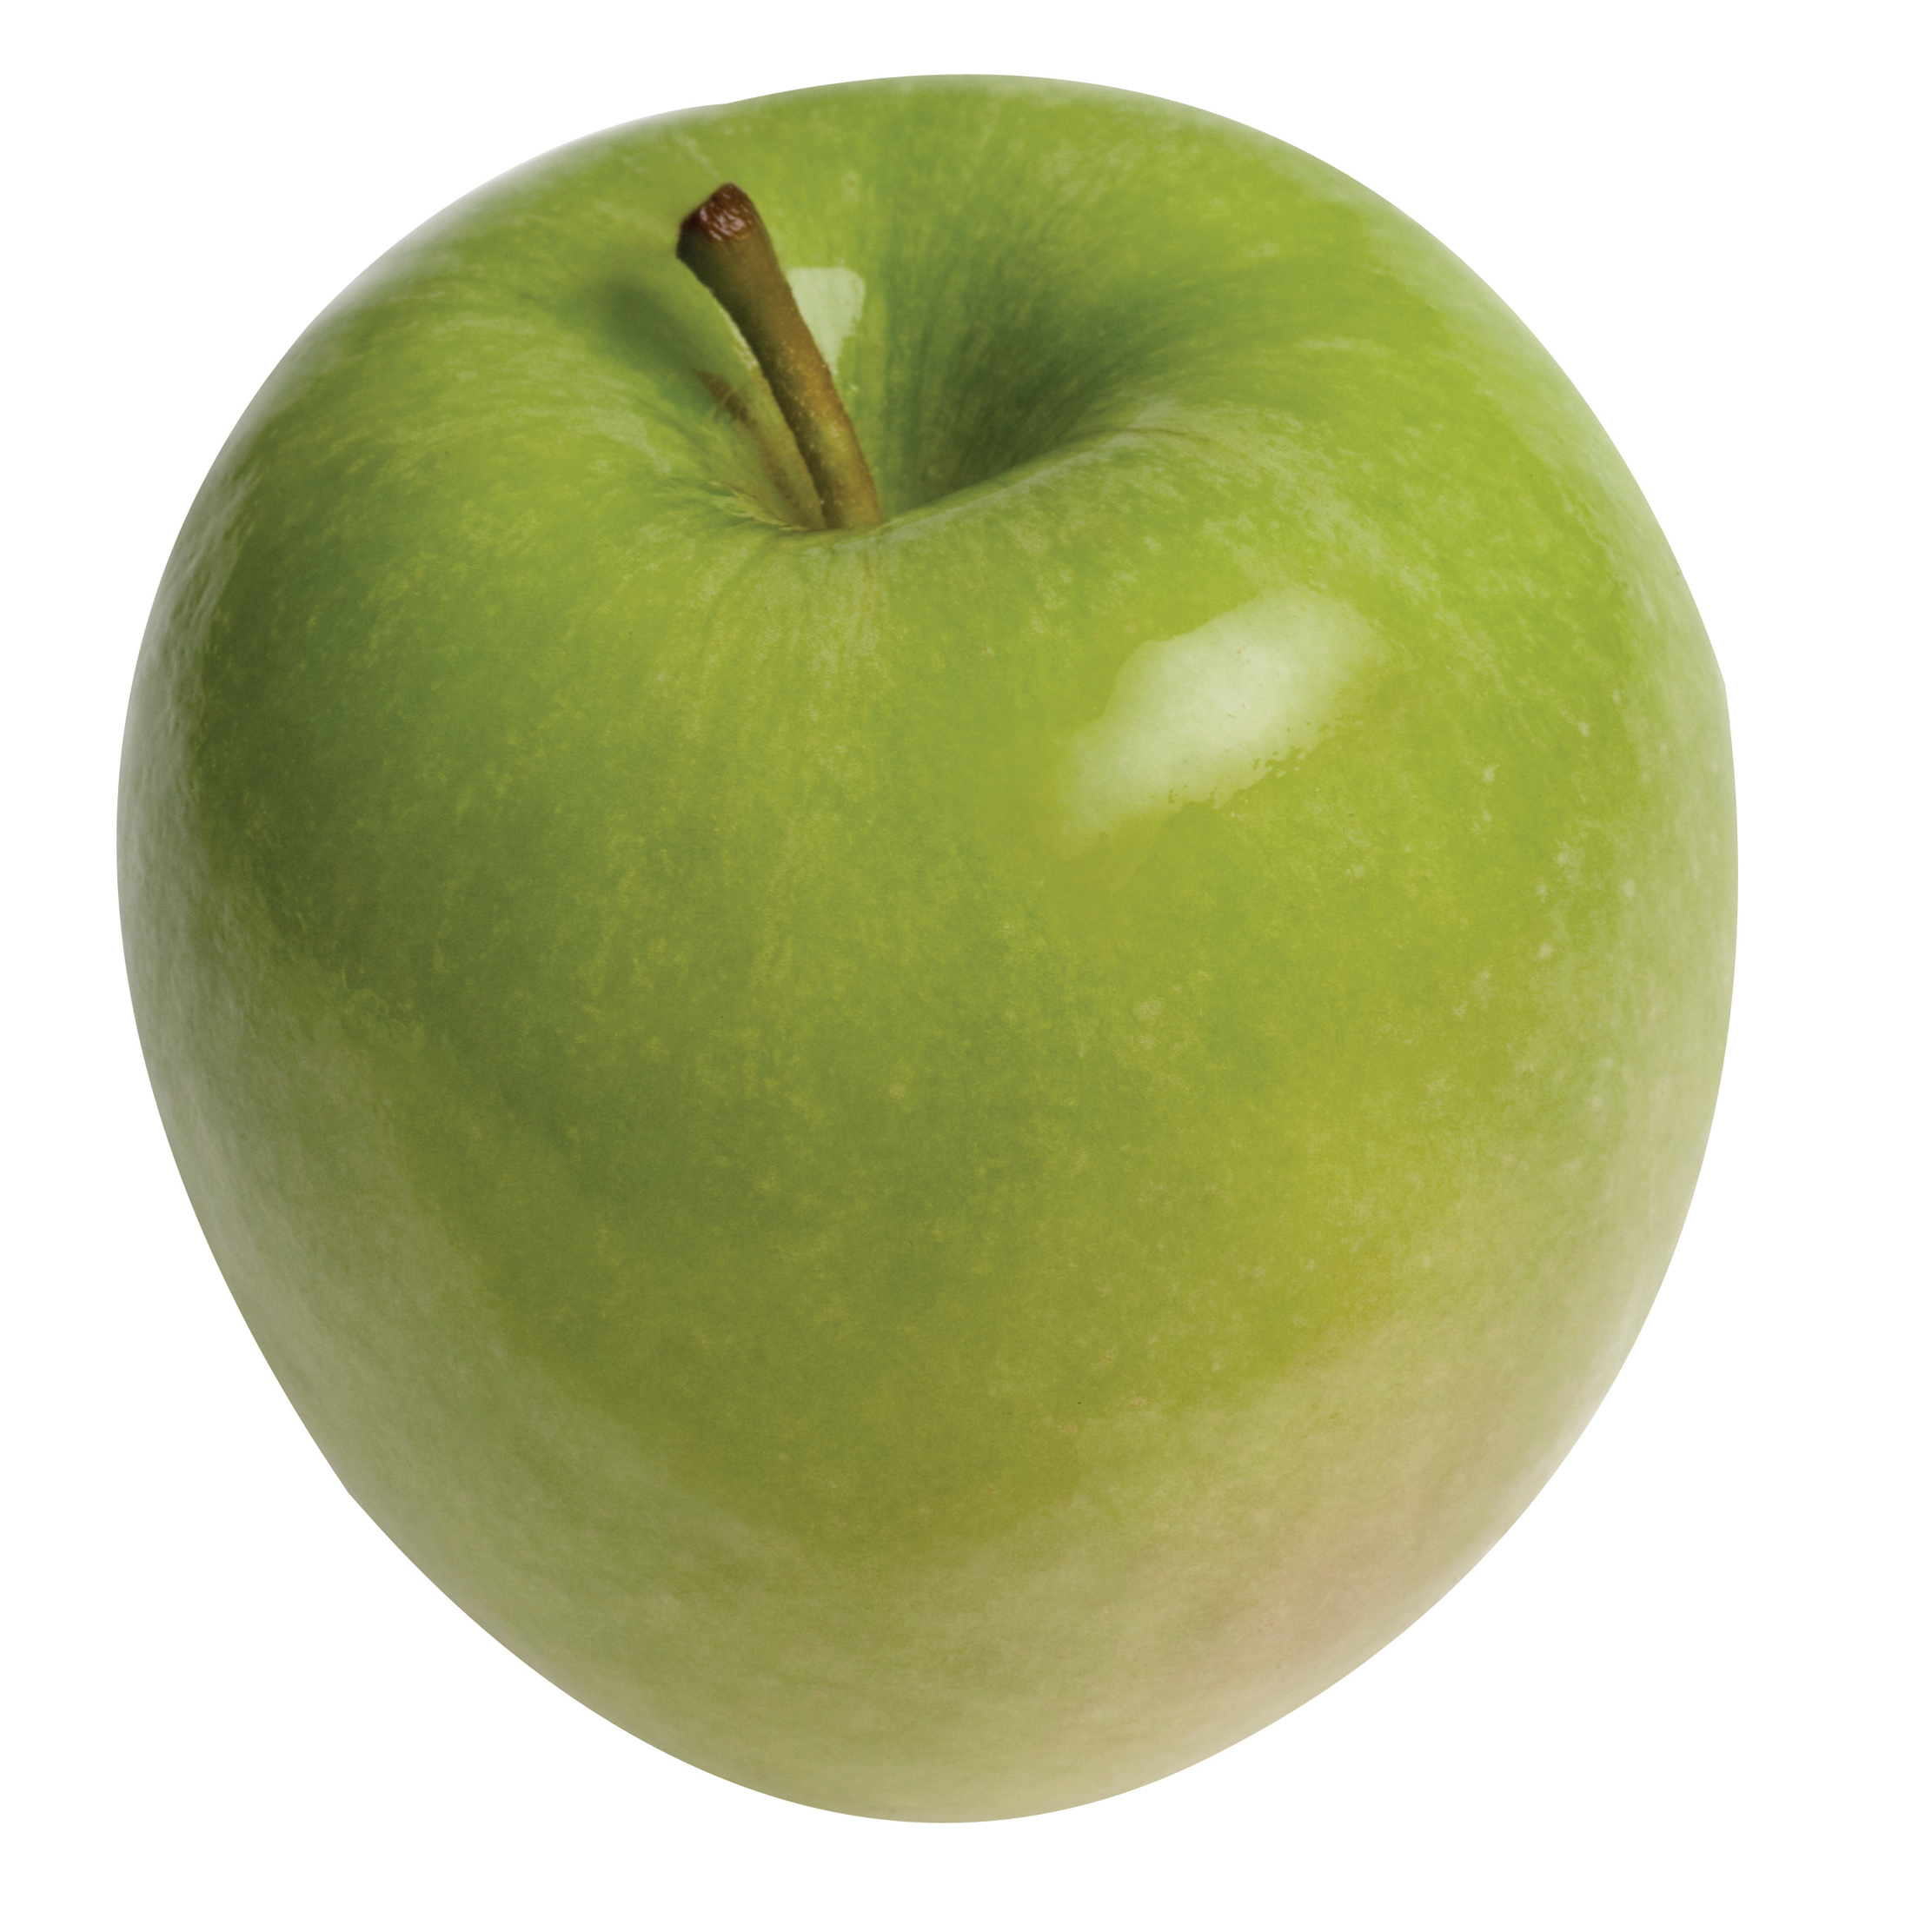


  Top-5 predictions:
    1. Granny Smith                    0.4297
    2. nail                            0.0019
    3. velvet                          0.0016
    4. lemon                           0.0014
    5. bagel                           0.0013

  Our class probabilities:
    Cat       0.0011  (best match: tabby)
    Dog       0.0010  (best match: Sussex spaniel)
    Fruit     0.4297  (best match: Granny Smith)

--- apple.jpg ---


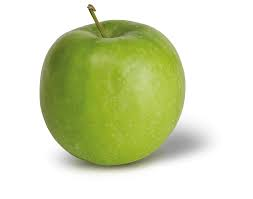


  Top-5 predictions:
    1. Granny Smith                    0.4832
    2. syringe                         0.0019
    3. lemon                           0.0016
    4. velvet                          0.0014
    5. nail                            0.0012

  Our class probabilities:
    Cat       0.0009  (best match: tabby)
    Dog       0.0010  (best match: Cardigan)
    Fruit     0.4832  (best match: Granny Smith)

--- small-breeds-hero.jpg ---


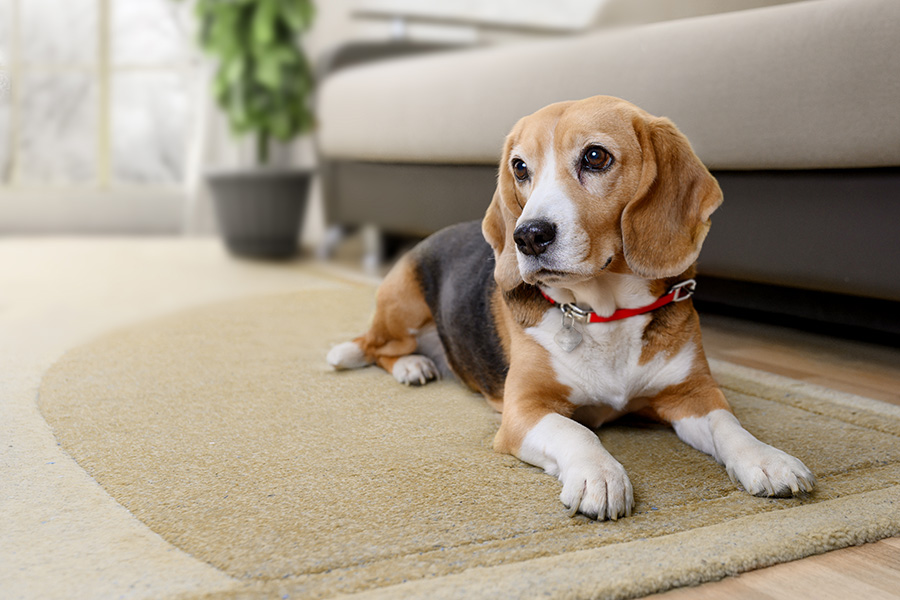


  Top-5 predictions:
    1. beagle                          0.2755
    2. Greater Swiss Mountain dog      0.0175
    3. Pembroke                        0.0130
    4. Pekinese                        0.0088
    5. Walker hound                    0.0075

  Our class probabilities:
    Cat       0.0022  (best match: Egyptian cat)
    Dog       0.2755  (best match: beagle)
    Fruit     0.0011  (best match: lemon)

--- dog3.jpeg ---


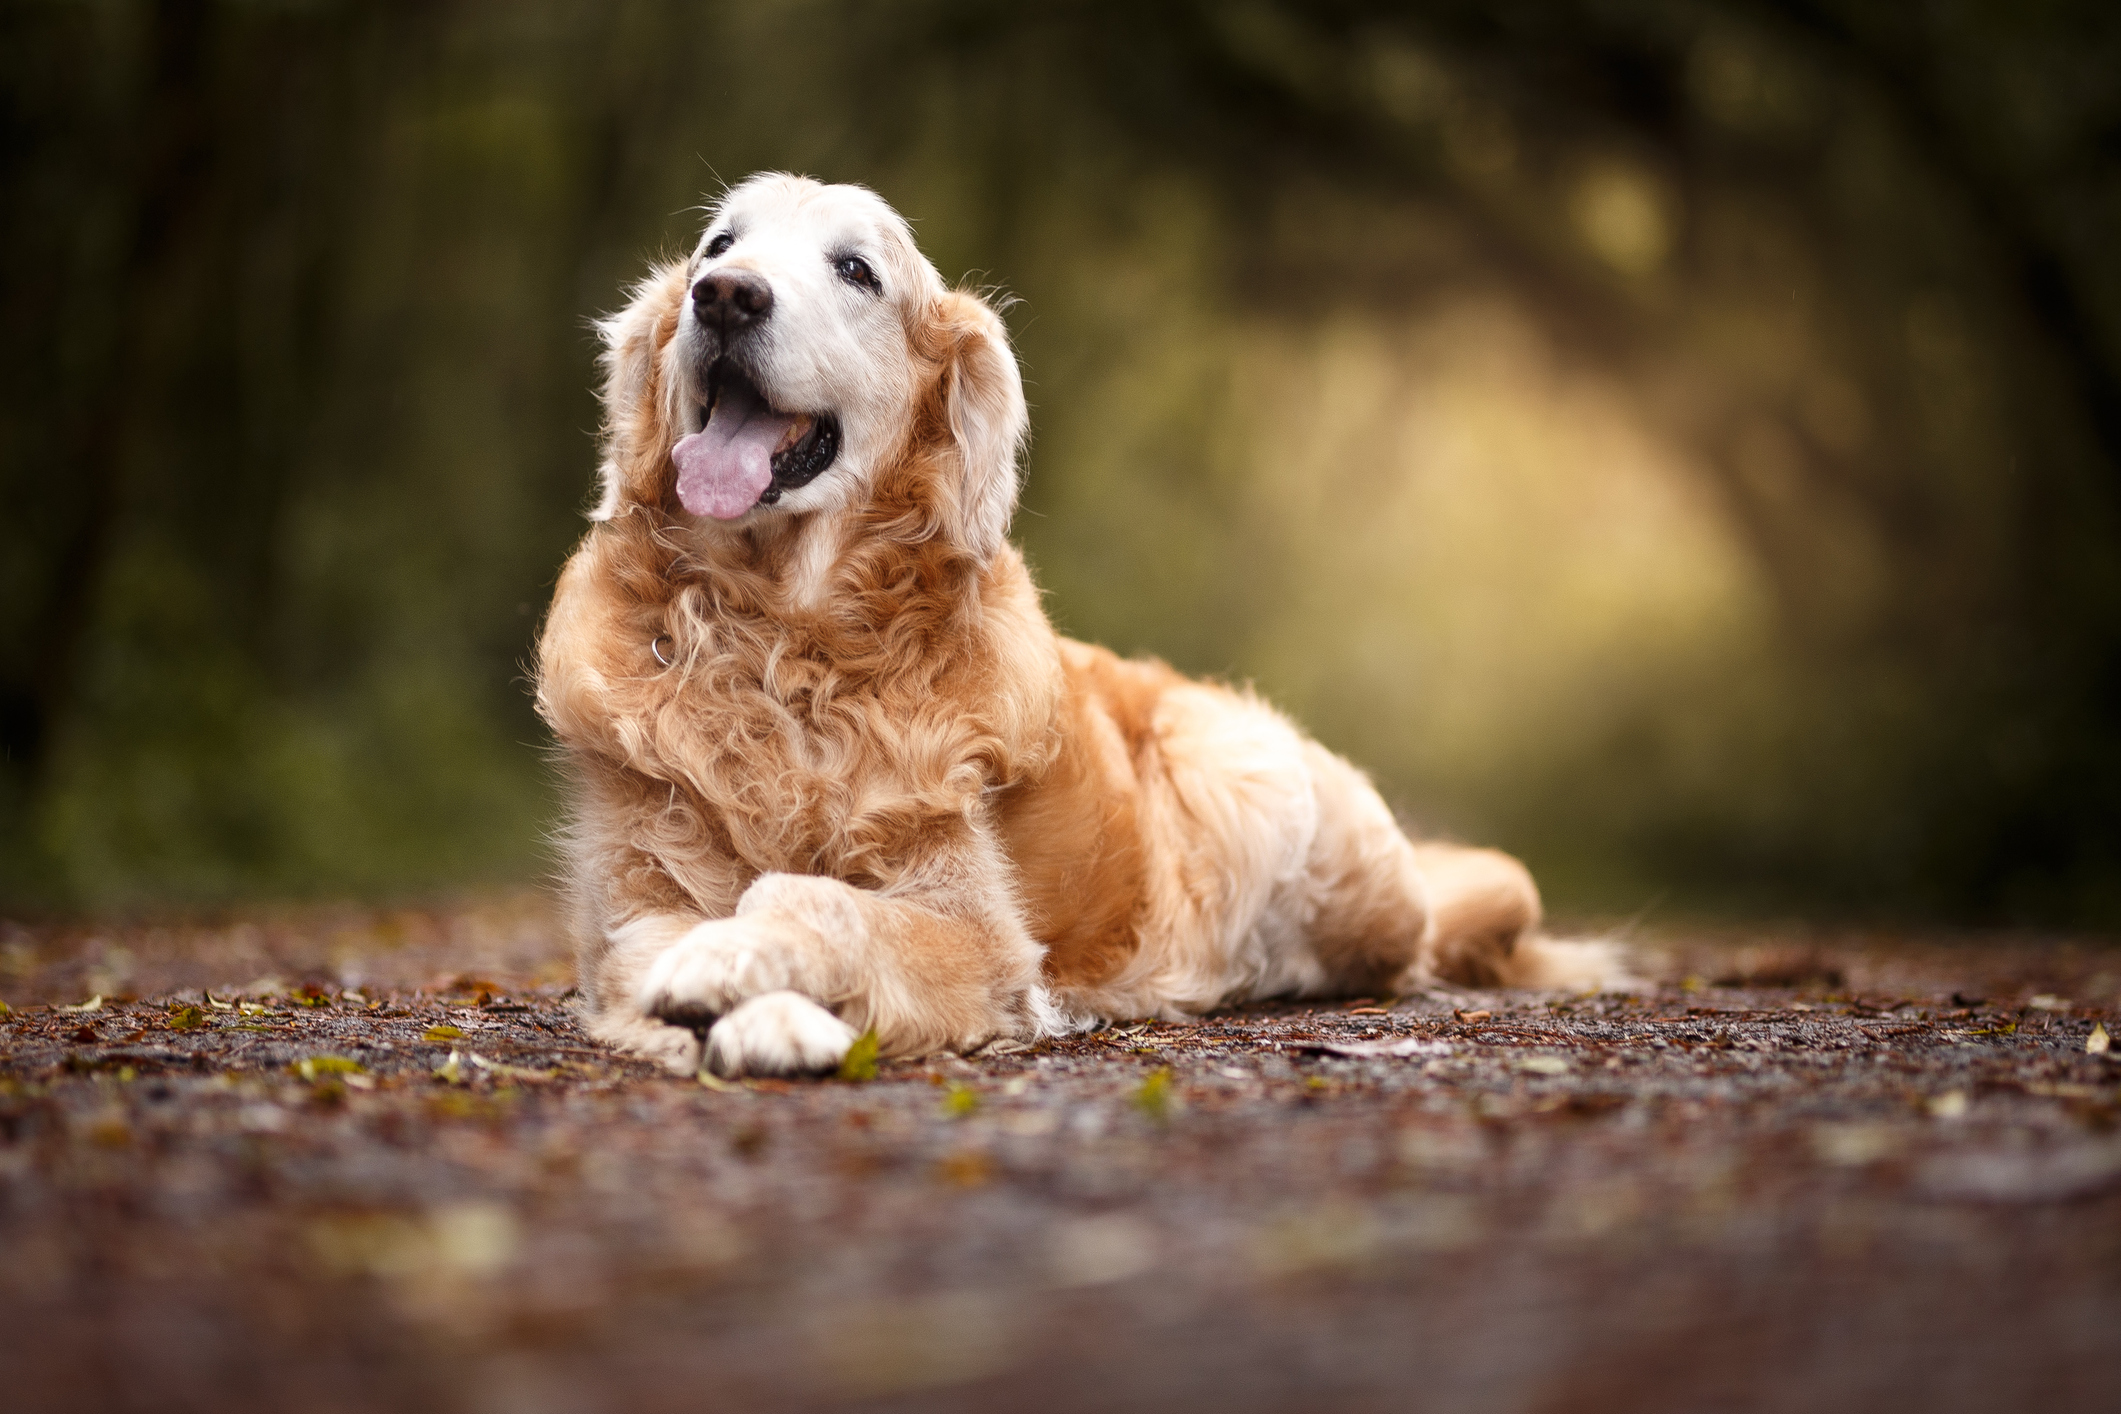


  Top-5 predictions:
    1. golden retriever                0.5188
    2. tennis ball                     0.0272
    3. kuvasz                          0.0129
    4. Leonberg                        0.0065
    5. Greater Swiss Mountain dog      0.0065

  Our class probabilities:
    Cat       0.0009  (best match: tiger cat)
    Dog       0.5188  (best match: golden retriever)
    Fruit     0.0005  (best match: Granny Smith)

--- dog1.jpg ---


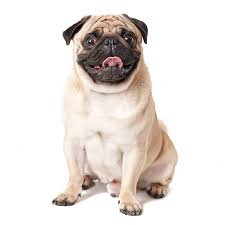


  Top-5 predictions:
    1. pug                             0.3540
    2. Brabancon griffon               0.0377
    3. bull mastiff                    0.0138
    4. tennis ball                     0.0038
    5. Boston bull                     0.0032

  Our class probabilities:
    Cat       0.0008  (best match: tabby)
    Dog       0.3540  (best match: pug)
    Fruit     0.0014  (best match: Granny Smith)

--- Tabby_cat_with_visible_nictitating_membrane.jpg ---


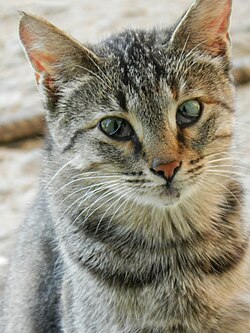


  Top-5 predictions:
    1. tabby                           0.2058
    2. tiger cat                       0.1323
    3. Egyptian cat                    0.0987
    4. lynx                            0.0043
    5. grey fox                        0.0020

  Our class probabilities:
    Cat       0.2058  (best match: tabby)
    Dog       0.0010  (best match: Norwegian elkhound)
    Fruit     0.0007  (best match: orange)

--- images.jpg ---


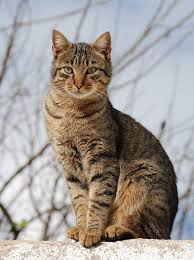


  Top-5 predictions:
    1. tabby                           0.2972
    2. Egyptian cat                    0.1659
    3. tiger cat                       0.0938
    4. lynx                            0.0253
    5. plastic bag                     0.0015

  Our class probabilities:
    Cat       0.2972  (best match: tabby)
    Dog       0.0010  (best match: vizsla)
    Fruit     0.0005  (best match: custard apple)


In [ ]:
import io
import urllib.request
from google.colab import files
from IPython.display import Image as IPImage

# Fetch ImageNet class names
_labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
with urllib.request.urlopen(_labels_url) as r:
    imagenet_class_names = [line.strip() for line in r.read().decode().splitlines()]

print("Upload an image:")
uploaded_files = files.upload()

if not uploaded_files:
    print("No images uploaded.")
else:
    for filename, file_bytes in uploaded_files.items():
        print(f"\n--- {filename} ---")
        display(IPImage(data=file_bytes, width=300))

        img_tensor = IMAGENET_TRANSFORM(
            Image.open(io.BytesIO(file_bytes)).convert("RGB")
        ).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            probs_single = torch.softmax(model(img_tensor), dim=1).cpu().numpy()[0]

        print("\n  Top-5 predictions:")
        for rank, idx in enumerate(probs_single.argsort()[::-1][:5], 1):
            print(f"    {rank}. {imagenet_class_names[idx]:<30s}  {probs_single[idx]:.4f}")

        print("\n  Our class probabilities:")
        for cls_name, imagenet_ids in IMAGENET_MAPPING.items():
            cls_prob = probs_single[imagenet_ids].max()
            best_id  = imagenet_ids[probs_single[imagenet_ids].argmax()]
            print(f"    {cls_name:<8s}  {cls_prob:.4f}  (best match: {imagenet_class_names[best_id]})")